# Attempt at song suggestion through Self-Organizing Map, K-means Clustering, and a NN

### Loading Data + Import Statements

In [ ]:
%%capture

!pip install minisom
!pip install spotipy

In [892]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy

In [893]:
songs = pd.read_csv('19000-spotify-songs/song_data.csv')
song_info = pd.read_csv('19000-spotify-songs/song_info.csv')

In [894]:
songs.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


### Prepping data

In [895]:
songs = songs.rename(columns={'audio_valence': 'valence'})

In [896]:
songs.insert(loc=1, column='song_artist', value=song_info['artist_name'])

In [897]:
features = songs.drop(labels=['song_name', 'song_artist', 'song_popularity', 'song_duration_ms', 'key', 'audio_mode'], axis=1)

In [898]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

## Self-Organizing Map

In [899]:
# training som

som = MiniSom(3, 3, 10, sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som.pca_weights_init(features_scaled)
som.train_batch(features_scaled, 5000, verbose=True)

 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 0.3864151341152763


In [900]:
winners = np.array([som.winner(x) for x in np.array(features_scaled)]).T
cluster_index = np.ravel_multi_index(winners, (3, 3))

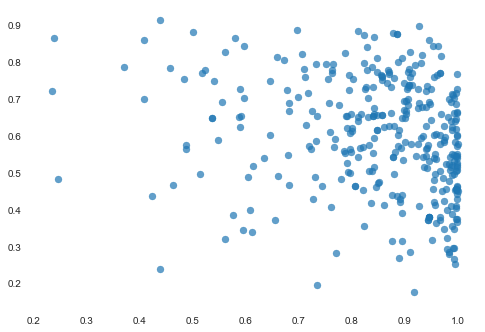

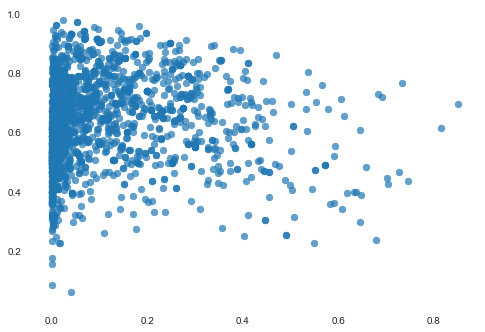

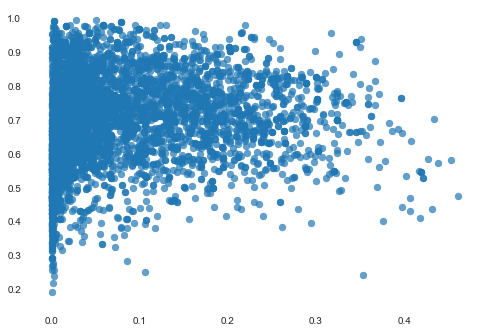

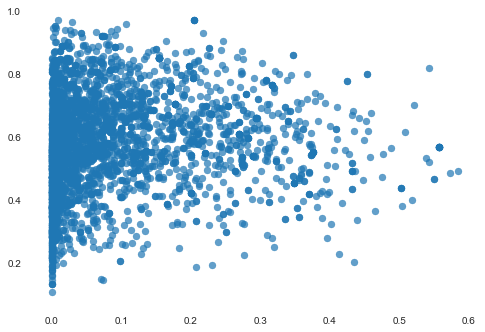

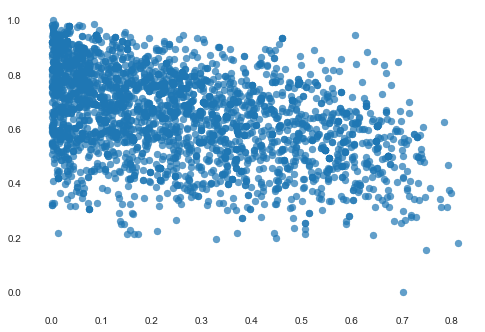

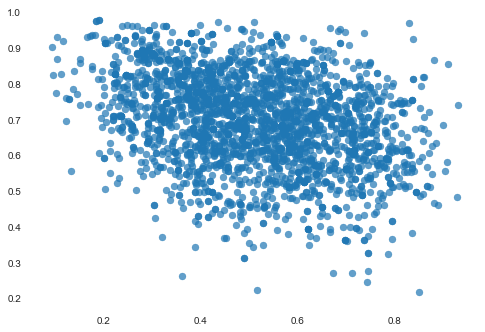

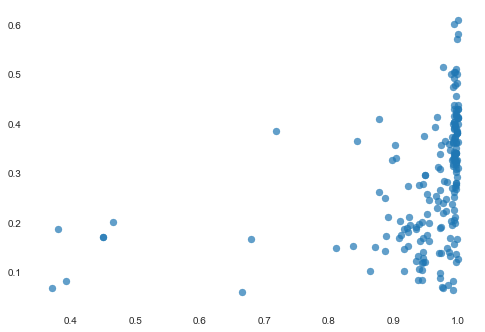

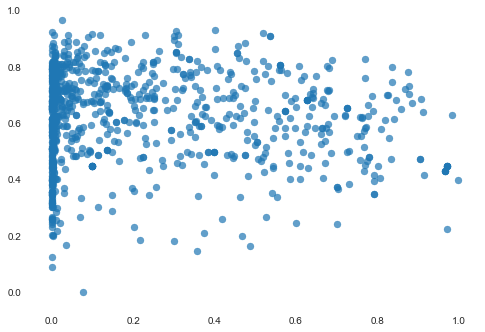

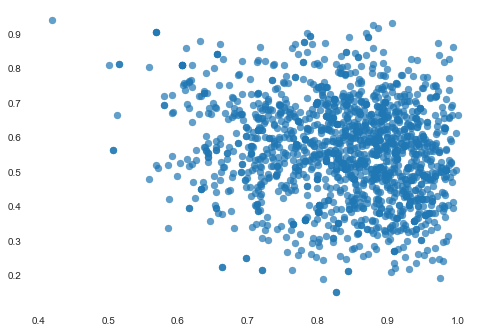

In [901]:
# plotting individual clusters

for c in np.unique(cluster_index):
    plt.scatter(np.array(features_scaled)[cluster_index == c, 0],
                np.array(features_scaled)[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)
    plt.show();

In [ ]:
# To-Do: use SOM clusters instead of KMeans

## K-Means Clustering

In [903]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_scaled)
    Sum_of_squared_distances.append(km.inertia_)

In [1196]:
from sklearn.metrics import silhouette_score

# Alternative scoring to elbow plot

for n_clusters in range(2,15):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(features_scaled)
    centers = clusterer.cluster_centers_

    score = silhouette_score (features_scaled, preds, metric='euclidean')
    print (f'n_clusters = {n_clusters}, silhouette score = {score})')

n_clusters = 2, silhouette score = 0.332113010135972)
n_clusters = 3, silhouette score = 0.19925297114498347)
n_clusters = 4, silhouette score = 0.21329916407902536)
n_clusters = 5, silhouette score = 0.22595724818394536)
n_clusters = 6, silhouette score = 0.21204061048492084)
n_clusters = 7, silhouette score = 0.2007880224439791)
n_clusters = 8, silhouette score = 0.20232709988138778)
n_clusters = 9, silhouette score = 0.1800397276208451)
n_clusters = 10, silhouette score = 0.16754194714596307)
n_clusters = 11, silhouette score = 0.16133281185768628)
n_clusters = 12, silhouette score = 0.15088247017091494)
n_clusters = 13, silhouette score = 0.14439193747781195)
n_clusters = 14, silhouette score = 0.14501459758334775)


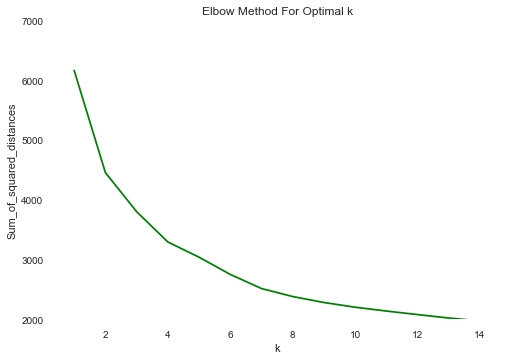

In [905]:
# elbow plot

plt.plot(K, Sum_of_squared_distances, 'gx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.ylim(2000, 7000)
plt.title('Elbow Method For Optimal k')
plt.show()

In [1197]:
# setting for reproducibility

np.random.seed(42)

# implementing kmeans

kmeans = KMeans(n_clusters=7)
kmeans.fit(features_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [907]:
# pulling cluster labels from kmeans

y_kmeans = kmeans.predict(features_scaled)

### Visualizing clusters using PCA

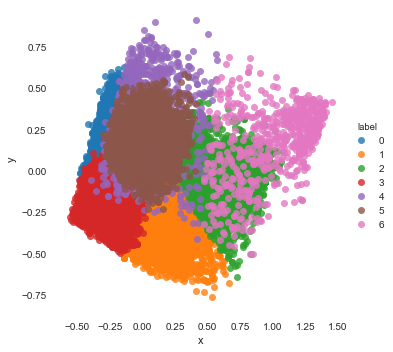

In [908]:
# pca to project into 2-D

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)

# plotting clusters

pc = pd.DataFrame(principal_components)
pc['label'] = y_kmeans
pc.columns = ['x', 'y','label']

cluster = sns.lmplot(data=pc, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

### Visualizing clusters using t-distributed Stochastic Neighbor Embedding

In [909]:
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-2, n_iter=5000)

tsne_components = tsne.fit_transform(features_scaled)

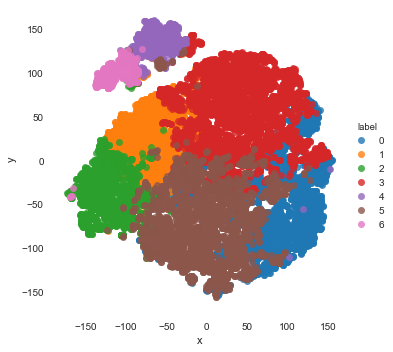

In [912]:
# plotting clusters

ts = pd.DataFrame(tsne_components)
ts['label'] = y_kmeans
ts.columns = ['x', 'y','label']

cluster = sns.lmplot(data=ts, x='x', y='y', hue='label', 
                   fit_reg=False, legend=True, legend_out=True)

# Predicting Labels with NN

## Pairing cluster labels with songs

In [911]:
songs['label'] = y_kmeans

songs = songs.sample(frac=1)
songs['label'].value_counts()

3    5344
5    4011
0    3459
1    2407
2    2104
4     913
6     597
Name: label, dtype: int64

In [1199]:
songs[songs['label'] == 6].sample(3)

,song_name,song_artist,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,valence,label
4802,Life Cykles,Falling Flowers,41,236400,0.928,0.669,0.0711,0.938,7,0.107,-20.716,0,0.0288,100.000,4,0.0446,6
13339,Forever Morning,Clarence Öfwerman,61,137772,0.976,0.360,0.1910,0.917,0,0.115,-19.335,1,0.0567,89.018,4,0.2050,6
16822,Migration,Bonobo,57,327400,0.763,0.561,0.5650,0.948,1,0.166,-12.374,1,0.0373,122.072,4,0.0392,6


### Data Prep and Model Building

In [913]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, y_kmeans, test_size=0.2)

y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

In [915]:
model = Sequential([
    Input(shape=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

inputs = Input(shape=(10,))

model.summary()

model.compile('nadam', 'categorical_crossentropy', metrics=['accuracy'])

In [918]:
model.fit(X_train, y_train_binary, epochs=10, batch_size=16, validation_split=.2)

Train on 12054 samples, validate on 3014 samples
Epoch 1/10
12054/12054 [==============================] - 2s 172us/sample - loss: 0.4873 - accuracy: 0.8335 - val_loss: 0.2399 - val_accuracy: 0.8942
Epoch 2/10
12054/12054 [==============================] - 1s 82us/sample - loss: 0.1507 - accuracy: 0.9452 - val_loss: 0.1581 - val_accuracy: 0.9250
Epoch 3/10
12054/12054 [==============================] - 1s 80us/sample - loss: 0.1184 - accuracy: 0.9560 - val_loss: 0.1322 - val_accuracy: 0.9390
Epoch 4/10
12054/12054 [==============================] - 1s 78us/sample - loss: 0.1044 - accuracy: 0.9593 - val_loss: 0.1434 - val_accuracy: 0.9376
Epoch 5/10
12054/12054 [==============================] - 1s 81us/sample - loss: 0.0930 - accuracy: 0.9628 - val_loss: 0.0724 - val_accuracy: 0.9751
Epoch 6/10
12054/12054 [==============================] - 1s 79us/sample - loss: 0.0841 - accuracy: 0.9657 - val_loss: 0.1453 - val_accuracy: 0.9333
Epoch 7/10
12054/12054 [==============================] 

In [919]:
# model evaluates well on test set

model.evaluate(X_test, y_test_binary)

3767/3767 [==============================] - 0s 22us/sample - loss: 0.0527 - accuracy: 0.9830


[0.05272024289121639, 0.98301035]

In [921]:
# returns predictions

model.predict_classes(X_test[:1])

array([2])

### Predicting from API

In [922]:
# credentials

client_credentials_manager = SpotifyClientCredentials(client_id='f13a6b55c2d949939455644bbd6f31d9', client_secret='c7c009270ff0483db51d25543563d55c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [923]:
# pulling a track from a playlist

playlist = sp.playlist('open.spotify.com/playlist/2YRe7HRKNRvXdJBp9nXFza')

track_info = dict(song=playlist['tracks']['items'][1]['track']['name'], 
                  artist=playlist['tracks']['items'][1]['track']['album']['artists'][0]['name'],
                  uri=playlist['tracks']['items'][1]['track']['uri'])

track_info

In [926]:
# pulling audio features for selected track

track_features = sp.audio_features(track_info['uri'])

track_features

In [1201]:
# trimming to only relevant features

track = [track_features[0][i] for i in features]

track

[0.124, 0.585, 0.52, 7.01e-05, 0.131, -6.136, 0.0712, 159.801, 4, 0.129]

In [930]:
# scaling for NN

track_scaled = scaler.transform(np.array(track).reshape(1, -1))

In [1202]:
# Success!

model.predict_classes(track_scaled)

array([5])

## Song Suggestion by euclidean distance

In addition to the clustering, we can treat the normalized features themselves as two series representing points and compute the distance between them in euclidean space - the closer together, the more similar they are. 

Across clusters I'm not sure how indicative of similarity this is, but within clusters it seems to work well.

I think we may be able to put some human compute power into investigating the clusters; my feeling is that we can probably associate moods or energy with them.

In [1218]:
# filtering songs by predicted label of sample track

songs = songs.sort_index()

filtered_songs = songs[songs['label'] == model.predict_classes(track_scaled)[0]]

In [1219]:
# dropping unnecessary columns and renaming for readability

songs_scaled = filtered_songs.join(pd.DataFrame(features_scaled)).drop(
    labels=features.columns, axis=1).drop(labels=['song_popularity', 'song_duration_ms', 'key', 'audio_mode'], axis=1)

songs_scaled = songs_scaled.rename(
    columns={0: features.columns[0],
             1: features.columns[1],
             2: features.columns[2],
             3: features.columns[3],
             4: features.columns[4],
             5: features.columns[5],
             6: features.columns[6],
             7: features.columns[7],
             8: features.columns[8],
             9: features.columns[9]})

In [1220]:
# computing distance from sample track for each track in cluster

songs_scaled['distance'] = [(np.linalg.norm(
    songs_scaled[features.columns][i:i+1] - track_scaled)) 
                         for i in range(0, len(songs_scaled))]

# filtering to only songs within a certain distance

neighbors = songs_scaled[songs_scaled['distance'] < .2].sort_values('distance')

In [1222]:
# prepping to create results array

track_scaled = pd.DataFrame(track_scaled).rename(
    columns={0: features.columns[0],
             1: features.columns[1],
             2: features.columns[2],
             3: features.columns[3],
             4: features.columns[4],
             5: features.columns[5],
             6: features.columns[6],
             7: features.columns[7],
             8: features.columns[8],
             9: features.columns[9]})

In [1257]:
# rejoining artist and title with song features

results = pd.DataFrame(track_info, 
                       index=[0], 
                       columns=['song', 'artist']
                      ).rename(columns={'song': 'song_name',
                                        'artist': 'song_artist'}
                              )

results = pd.concat([results, track_scaled], axis=1)

results['label'] = model.predict_classes(track_scaled)

# adding sample track to filtered songs

results = pd.concat([results, neighbors])

# dropping duplicates where name and artist are identical

results = results.drop_duplicates(subset=['song_name', 'song_artist'])

# Results!

### Sample Track + 5 Suggested Tracks by Distance

In [1258]:
pd.concat([results[:1], results.sample(5).sort_values('distance')])

,song_name,song_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence,label,distance
0,rockstar (feat. 21 Savage),Post Malone,0.124497,0.592705,0.520006,0.000070,0.123167,0.808664,0.075664,0.659468,0.8,0.131098,5,NaN
11578,Chewing Gum,Blood Orange,0.144577,0.630193,0.514996,0.016550,0.187776,0.763487,0.154091,0.694397,0.8,0.220528,5,0.153913
16927,4AM In London,Benjamin Francis Leftwich,0.048493,0.541033,0.444851,0.000073,0.107784,0.722400,0.037301,0.643823,0.8,0.084146,5,0.160293
3647,Disrespectful,GASHI,0.022087,0.719352,0.547062,0.000061,0.111886,0.757143,0.073433,0.627287,0.8,0.144309,5,0.176793
3155,Feels Like Summer,Childish Gambino,0.162650,0.561297,0.596164,0.004835,0.071377,0.757168,0.138151,0.683928,0.8,0.259146,5,0.185737
15114,Helium (Sia vs. David Guetta & Afrojack),Sia,0.098091,0.549139,0.587145,0.000000,0.193929,0.808441,0.037194,0.565022,0.8,0.246951,5,0.189558


### Random Song Suggestion Based On Sample Track

In [1264]:
results.sample(1)

,song_name,song_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence,label,distance
18611,Echo,Incubus,0.18273,0.595745,0.543054,0.000518,0.101631,0.698139,0.02848,0.56104,0.8,0.213415,5,0.187888


### Sample Track + All Tracks In Cluster, By Distance

In [1267]:
pd.concat([results[:1], results.sort_values('distance')[:-1]])

,song_name,song_artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,valence,label,distance
0,rockstar (feat. 21 Savage),Post Malone,0.124497,0.592705,0.520006,0.000070,0.123167,0.808664,0.075664,0.659468,0.8,0.131098,5,NaN
3699,rockstar,Post Malone,0.128513,0.587639,0.531029,0.000127,0.135473,0.796397,0.082465,0.659406,0.8,0.143293,5,0.025694
10340,¡Corre!,Jesse & Joy,0.127509,0.485309,0.476917,0.000000,0.142652,0.790078,0.038576,0.627151,0.8,0.129065,5,0.128642
11772,Deep Down,Zhavia Ward,0.014256,0.593718,0.564098,0.000000,0.123167,0.822615,0.078427,0.709964,0.8,0.163618,5,0.133820
17366,Hero,Enrique Iglesias,0.154618,0.578521,0.640255,0.000011,0.138550,0.823334,0.044846,0.627143,0.8,0.170732,5,0.139949
17691,Timeless,James Blake,0.151606,0.656535,0.558085,0.000003,0.095477,0.761802,0.100213,0.577737,0.8,0.194106,5,0.143089
1595,Trouble,Coldplay,0.189758,0.568389,0.547062,0.001575,0.163163,0.774961,0.034113,0.576742,0.8,0.193089,5,0.143990
11590,Oneway,Pillow T.,0.064758,0.677812,0.504975,0.000036,0.172393,0.772607,0.094899,0.577827,0.8,0.168699,5,0.152349
11578,Chewing Gum,Blood Orange,0.144577,0.630193,0.514996,0.016550,0.187776,0.763487,0.154091,0.694397,0.8,0.220528,5,0.153913
2465,Wylin',Always Never,0.112449,0.498480,0.488942,0.001725,0.082248,0.766114,0.044633,0.676780,0.8,0.035366,5,0.154607
